In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import os
from random import shuffle

In [4]:
import keras_tuner

In [4]:
! conda list

# packages in environment at C:\Anaconda3_64\envs\minitf:
#
# Name                    Version                   Build  Channel
absl-py                   0.15.0                   pypi_0    pypi
anyio                     3.6.1                    pypi_0    pypi
argon2-cffi               21.3.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-generator           1.10                     pypi_0    pypi
attrs                     21.4.0                   pypi_0    pypi
babel                     2.10.3                   pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
bleach                    4.1.0                    pypi_0    pypi
ca-certificates           2022.6.15            h5b45459_0    conda-forge
cached-property           1.5.2                    pypi_0    pypi
cachetools                4.2.4                    pypi_0    pypi
certifi 

In [ ]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [ ]:
x_size = 230
y_size = 230
def load_features(name):
    decoded = name.decode("UTF-8")
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            features = np.array([file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)

In [ ]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [ ]:
print(len(pkl_files))

In [ ]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [ ]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [ ]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [ ]:
print(len(pkl_files_steel))

In [ ]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
shuffle(pkl_files)

In [ ]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [ ]:
print(len(pkl_files))

In [2]:
dataset_len=len(pkl_files)

NameError: name 'pkl_files' is not defined

In [92]:
dataset = tf.data.Dataset.from_tensor_slices((pkl_files))

def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.uint16, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

dataset = dataset.map(data_loader)
               # load_features, [filename], [tf.uint16, tf.string])))

In [93]:
dataset.shuffle(100)


train_size = np.floor(0.8 * dataset_len)
valid_size = np.floor(0.1 * dataset_len)
test_size = np.floor(0.1 * dataset_len)

train = dataset.take(train_size)
remaining = dataset.skip(train_size)
valid = remaining.take(valid_size)
test = remaining.skip(valid_size)

In [94]:
train = train.shuffle(100,  reshuffle_each_iteration=True)

In [123]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),
    # layers.RandomCrop(120,120, seed=in_seed, input_shape=(x_size,y_size,4)),
    layers.CenterCrop(120,120, ),
    layers.Rescaling(1./10000),#,input_shape=(240,240,4)),
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed),
])

In [124]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [125]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(230, 230, 4)
(3,)


In [126]:
train

<ShuffleDataset shapes: (<unknown>, <unknown>), types: (tf.uint16, tf.int32)>

In [127]:
model = tf.keras.Sequential([
    resize_rescale_augment,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [128]:
model.build()

In [129]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 120, 120, 4)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 120, 120, 16)      592       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 64)      

In [130]:
# image_batch, labels_batch = next(iter(dataset))

In [131]:
# validation_inputs, validation_targets = next(iter(valid))

In [132]:
# next(iter(valid))

In [133]:
epochs=20
batch_size = 40
history = model.fit(
  train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
  validation_data=valid.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
    validation_steps=1,
  epochs=epochs,
)

Epoch 1/20
146/146 [==============================] - 94s 630ms/step - loss: 0.8237 - binary_accuracy: 0.7534 - val_loss: 0.8219 - val_binary_accuracy: 0.7583
Epoch 2/20
146/146 [==============================] - 95s 651ms/step - loss: 0.6638 - binary_accuracy: 0.8165 - val_loss: 0.8455 - val_binary_accuracy: 0.7583
Epoch 3/20
146/146 [==============================] - 98s 669ms/step - loss: 0.6346 - binary_accuracy: 0.8235 - val_loss: 0.8744 - val_binary_accuracy: 0.7500
Epoch 4/20
146/146 [==============================] - 96s 657ms/step - loss: 0.6195 - binary_accuracy: 0.8297 - val_loss: 0.8758 - val_binary_accuracy: 0.7583
Epoch 5/20
146/146 [==============================] - 103s 705ms/step - loss: 0.6079 - binary_accuracy: 0.8340 - val_loss: 0.8215 - val_binary_accuracy: 0.7667
Epoch 6/20
146/146 [==============================] - 97s 662ms/step - loss: 0.5936 - binary_accuracy: 0.8389 - val_loss: 0.8307 - val_binary_accuracy: 0.7667
Epoch 7/20
146/146 [=========================

In [135]:
history.history

{'loss': [0.8236790299415588,
  0.6638243198394775,
  0.6345580220222473,
  0.6195027232170105,
  0.6078817844390869,
  0.5935801267623901,
  0.5932939052581787,
  0.5859193801879883,
  0.5768601298332214,
  0.5781650543212891,
  0.5697368383407593,
  0.5770413875579834,
  0.5717342495918274,
  0.5622901916503906,
  0.5620269775390625,
  0.563075840473175,
  0.5577449202537537,
  0.552181601524353,
  0.5498566627502441,
  0.5463148355484009],
 'binary_accuracy': [0.7534244656562805,
  0.8164952397346497,
  0.8235159516334534,
  0.829680323600769,
  0.8340182304382324,
  0.8388698697090149,
  0.8343607187271118,
  0.8325344324111938,
  0.8425797820091248,
  0.8397263884544373,
  0.8429225087165833,
  0.838127851486206,
  0.8386415243148804,
  0.8396691679954529,
  0.838127851486206,
  0.83869868516922,
  0.8446916937828064,
  0.8452625274658203,
  0.8482875227928162,
  0.8481733202934265],
 'val_loss': [0.8218598365783691,
  0.845478892326355,
  0.8744365572929382,
  0.8758195638656616,

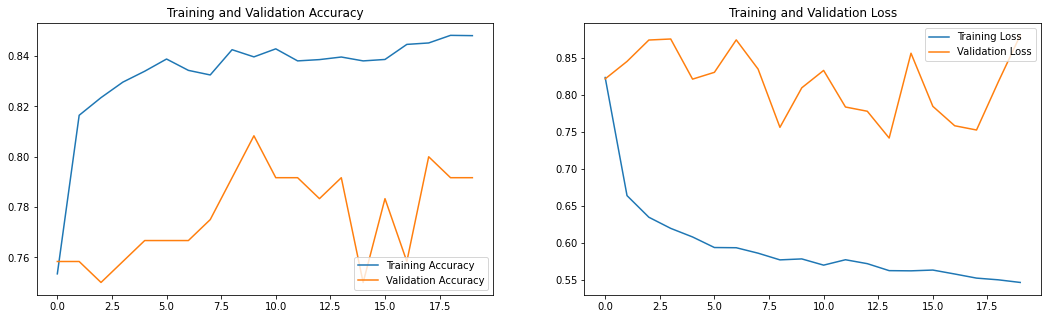

In [136]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [134]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)
next_element = iterator.get_next()
resize_and_rescale(next_element[0])

<tf.Tensor: shape=(120, 120, 4), dtype=float32, numpy=
array([[[0.0353    , 0.056     , 0.06659999, 0.2198    ],
        [0.0437    , 0.0631    , 0.0741    , 0.23089999],
        [0.0413    , 0.0601    , 0.0692    , 0.20719999],
        ...,
        [0.0318    , 0.0448    , 0.07009999, 0.1776    ],
        [0.0298    , 0.0396    , 0.0633    , 0.15879999],
        [0.0254    , 0.0383    , 0.054     , 0.14729999]],

       [[0.0301    , 0.052     , 0.0524    , 0.2382    ],
        [0.0307    , 0.0556    , 0.0596    , 0.249     ],
        [0.0302    , 0.0552    , 0.058     , 0.2514    ],
        ...,
        [0.0249    , 0.0361    , 0.0549    , 0.15179999],
        [0.0271    , 0.0346    , 0.0519    , 0.1415    ],
        [0.0234    , 0.0365    , 0.0507    , 0.14479999]],

       [[0.0219    , 0.0392    , 0.0364    , 0.1656    ],
        [0.0204    , 0.0389    , 0.0402    , 0.18079999],
        [0.0245    , 0.0482    , 0.0456    , 0.2166    ],
        ...,
        [0.0175    , 0.0266    ,

In [ ]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3], axis=2))
    plt.title(convert_onehot(next_element))